<a href="https://colab.research.google.com/github/goldenspring6622/CS114.M21.N02/blob/main/Toxic_Comment_Detection_On_Youtube_Football_Livestream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### IMPORT PACKAGES

In [1]:
! pip install openpyxl


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip3 install  xlrd==1.2.0
!pip install --upgrade pandas
!pip install underthesea
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import time
from pandas import Series, DataFrame
import xlrd
from sklearn.feature_extraction.text import TfidfVectorizer
from xlrd import open_workbook
from underthesea import word_tokenize #https://pypi.org/project/underthesea/ anhv.ict91@gmail.com

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1. Preprocess

In [4]:
!pip list

Package                       Version
----------------------------- ------------------------------
absl-py                       1.1.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.2.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.12.1
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.4.0
audioread                     2.1.9
autograd                      1.4
Babel                         2.10.2
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        5.0.0
blis                          0.7.7
bokeh                         2.3.3
branca                        0.5.0
bs4                           0.0.1
CacheControl                  0.

In [5]:
dataTrainUIT = open_workbook("/content/Dataset.xlsx", encoding_override='latin')
df = pd.read_excel(dataTrainUIT)


In [6]:
df.head()

,Content,Final
0,cặc,1
1,da kieu gi may dua,0
2,cố lên vn,0
3,cl mệ nó,1
4,Việt Nam ăn chắc rồi🇻🇳🇻🇳🇻🇳🇻🇳🇻🇳,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Count of Toxic Comment of Dataset')

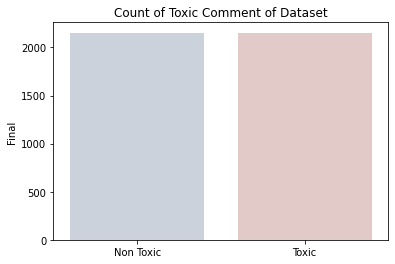

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(['Non Toxic', 'Toxic'], df['Final'].map({0:"Non Toxic", 1: "Toxic"}).value_counts(ascending=True), alpha=0.8,palette="vlag")

plt.title('Count of Toxic Comment of Dataset')

In [8]:
from tensorflow.keras.layers import TextVectorization

In [9]:
X = df['Content']
y = df['Final']
WordSeg = []
for i in range(len(X)):
        sentence_strip = str(X[i]).strip()# Remove spaces at begin & end
        WordSeg.append(word_tokenize(sentence_strip, format='text')) # format text: add "_" where text is phrases.
X = pd.DataFrame(WordSeg) # Update new sentences
print(X)

                                                      0
0                                                   cặc
1                                    da kieu gi may dua
2                                             cố lên vn
3                                              cl mệ nó
4              Việt_Nam ăn_chắc rồi 🇻_🇳_🇻_🇳_🇻_🇳_🇻_🇳_🇻_🇳
...                                                 ...
4294                              đcm trọng_tài mua rồi
4295                                     chừng nào đá v
4296                                                Hòa
4297  TÀI NHƯ LỒN TÀI NHƯ LỒN TÀI NHƯ LỒN TÀI NHƯ LỒ...
4298                                       bố mấythg đơ

[4299 rows x 1 columns]


In [10]:
MAX_FEATURES = 200000 # number of words in the vocab

In [11]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=50,
                               output_mode='int')

In [12]:
vectorizer.adapt(X.values)

In [13]:
vectorized_text = vectorizer(X.values)

In [14]:
print(vectorized_text)

tf.Tensor(
[[ 204    0    0 ...    0    0    0]
 [ 134  852  508 ...    0    0    0]
 [  64   29    4 ...    0    0    0]
 ...
 [ 318    0    0 ...    0    0    0]
 [ 108   96  106 ...  106    0    0]
 [ 234 2938 1208 ...    0    0    0]], shape=(4299, 50), dtype=int64)


In [15]:
print(vectorized_text)

tf.Tensor(
[[ 204    0    0 ...    0    0    0]
 [ 134  852  508 ...    0    0    0]
 [  64   29    4 ...    0    0    0]
 ...
 [ 318    0    0 ...    0    0    0]
 [ 108   96  106 ...  106    0    0]
 [ 234 2938 1208 ...    0    0    0]], shape=(4299, 50), dtype=int64)


In [16]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [17]:
train = dataset.take(int(len(dataset)*.6))
val = dataset.skip(int(len(dataset)*.6)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.8)).take(int(len(dataset)*.2))

# 2. Create Sequential Model

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [21]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(512, activation='relu'))
# Final layer 
model.add(Dense(1, activation='sigmoid'))

In [22]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 512)               131584    
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                        

In [24]:
history = model.fit(train, epochs=15, validation_data=val)

Epoch 1/15
161/161 [==============================] - 23s 115ms/step - loss: 0.5822 - val_loss: 0.3974
Epoch 2/15
161/161 [==============================] - 18s 110ms/step - loss: 0.3296 - val_loss: 0.2133
Epoch 3/15
161/161 [==============================] - 18s 110ms/step - loss: 0.2109 - val_loss: 0.1281
Epoch 4/15
161/161 [==============================] - 18s 109ms/step - loss: 0.1380 - val_loss: 0.1232
Epoch 5/15
161/161 [==============================] - 18s 110ms/step - loss: 0.1129 - val_loss: 0.0837
Epoch 6/15
161/161 [==============================] - 18s 109ms/step - loss: 0.0937 - val_loss: 0.0805
Epoch 7/15
161/161 [==============================] - 18s 110ms/step - loss: 0.0716 - val_loss: 0.0508
Epoch 8/15
161/161 [==============================] - 18s 110ms/step - loss: 0.0705 - val_loss: 0.0566
Epoch 9/15
161/161 [==============================] - 18s 110ms/step - loss: 0.0629 - val_loss: 0.0459
Epoch 10/15
161/161 [==============================] - 18s 110ms/step - l

In [25]:
from matplotlib import pyplot as plt

<Figure size 576x360 with 0 Axes>

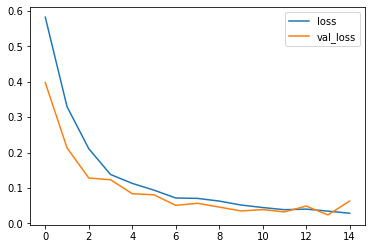

In [26]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [27]:
input_text = vectorizer(['tụi m giỏi thì vào mà đá, ở đó mà sủa ngu'])

In [28]:
print(input_text)

tf.Tensor(
[[178  37 203  19  23  12   2 206 131  12 362  24   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]], shape=(1, 50), dtype=int64)


In [29]:
res = model.predict(input_text)

In [30]:
print(res)

[[1.]]


In [31]:
(res > 0.5).astype(int)

array([[1]])

In [32]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [33]:
(model.predict(batch_X) > 0.5).astype(int)

array([[1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0]])

In [34]:
res.shape

(1, 1)

In [35]:
input_text = vectorizer(['Việt Nam vô địch'])

In [36]:
print(input_text)

tf.Tensor(
[[ 63  48 111 914   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]], shape=(1, 50), dtype=int64)


In [37]:
res = model.predict(input_text)

In [38]:
print(res)

[[0.45279163]]


In [39]:
(res > 0.5).astype(int)

array([[0]])

In [40]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [41]:
(model.predict(batch_X) > 0.5).astype(int)

array([[1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0]])

In [42]:
res.shape

(1, 1)

In [43]:
input_text = vectorizer(['Việt Nam vô địt'])

In [44]:
print(input_text)

tf.Tensor(
[[ 63  48 111 303   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]], shape=(1, 50), dtype=int64)


In [45]:
res = model.predict(input_text)

In [46]:
print(res)

[[0.999986]]


In [47]:
(res > 0.5).astype(int)

array([[1]])

In [48]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [49]:
(model.predict(batch_X) > 0.5).astype(int)

array([[0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1]])

In [50]:
res.shape

(1, 1)

In [51]:
input_text = vectorizer(['chửi chết nó đi anh em'])

In [52]:
print(input_text)

tf.Tensor(
[[170 116  11   8 120 185   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]], shape=(1, 50), dtype=int64)


In [53]:
res = model.predict(input_text)

In [54]:
print(res)

[[0.984918]]


In [55]:
(res > 0.5).astype(int)

array([[1]])

In [56]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [57]:
(model.predict(batch_X) > 0.5).astype(int)

array([[1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0]])

In [58]:
res.shape

(1, 1)

# 4. Evaluate Model

In [59]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [60]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [61]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    print(batch)
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    print(y_true)
    yhat = yhat.flatten()
    print(yhat)
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

(array([[  31,   98, 1044,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [3929,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [  57, 1066, 1758,    6,   81,   14,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,  

In [62]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.9492273926734924, Recall:1.0, Accuracy:0.3962264060974121


In [69]:
a=[9.4120628e-01, 9.9999374e-01, 9.9473757e-01, 9.9997628e-01,
  9.9971211e-01, 9.9999952e-01, 1.0000000e+00,
 9.9999303e-01, 9.9993360e-01 , 9.9983990e-01, 
 1.0000000e+00]
import statistics
x = statistics.mean(a)
print(x)

0.9941265481818182


In [66]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    print(y_true)
    print(yhat)
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)
    print(pre.result().numpy(),re.result().numpy(),acc.result().numpy())

[1 1 1 0 1 0 0 1 1 1 1 1 0 1 0 1]
[9.4120628e-01 9.9999374e-01 9.9473757e-01 6.0231268e-02 9.9997628e-01
 5.0739497e-02 5.6452155e-02 9.9971211e-01 9.9999952e-01 1.0000000e+00
 9.9999303e-01 9.9993360e-01 4.1600943e-01 9.9983990e-01 9.6905231e-04
 1.0000000e+00]
0.95661974 0.9994114 0.32394367
[1 1 1 1 1 0 1 0 0 1 0 0 0 0 0 1]
[1.0000000e+00 9.9999356e-01 9.9897015e-01 9.9888915e-01 1.0000000e+00
 3.2511751e-05 1.0000000e+00 3.1310618e-03 3.7930101e-02 9.9989706e-01
 1.8590689e-02 4.8890710e-04 2.8003822e-07 1.3927552e-05 2.2128224e-04
 9.9811143e-01]
0.95681435 0.9994142 0.3271028
[0 1 0 1 0 1 0 0 1 0 0 0 1 1 1 1]
[7.4295822e-05 1.0000000e+00 2.3387969e-03 9.9999660e-01 1.0604858e-03
 9.9620819e-01 3.6311144e-07 4.6509231e-07 1.0000000e+00 1.0172129e-03
 2.3521602e-02 3.0392408e-04 9.7088265e-01 9.9995965e-01 9.9999666e-01
 9.9967384e-01]
0.9570072 0.9994169 0.33023256
[0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0]
[8.3686113e-03 1.8308461e-03 1.2229979e-03 6.3665357e-05 1.0000000e+00
 7.8704953e-